In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

with open('c_states_dict_v4.pkl', 'rb') as f:
    c_states = pickle.load(f)

    
# with open('c_states_dict_acer_2.pkl', 'rb') as f:
#     c_states_test = pickle.load(f)

# with open('states_dict_v2.pkl', 'rb') as f:
    # states = pickle.load(f)

print(len(c_states))
print(c_states[5].shape)

5
(2500, 18, 7, 120)


In [11]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class TEST_FrequencyDetectionEnv(gym.Env):
    """Custom Environment for Frequency Objective Response Detection that follows gymnasium interface"""

    def __init__(self, data):
        super(TEST_FrequencyDetectionEnv, self).__init__()

        self.data = data
        self.episodes = data.shape[0]-1
        self.frequencies = data.shape[1]-1
        self.measures = data.shape[2]
        self.windows = data.shape[3]-1
        self.current_episode = 0
        self.current_window = 2
        self.current_frequency = 0

        # Action space: 0 (no detection) or 1 (detection)
        self.action_space = spaces.Discrete(2)

        # Observation space: 5 measures for each of the 4 frequencies (1 focus + 3 noise)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(4*self.measures,), dtype=np.float32)
        # self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.measures,), dtype=np.float32)

        # Initialize the internal state
        self.state = None
        self.false_positives = 0
        self.true_positives = 0
        self.fp_rate = 0
        self.tp_rate = 0   
        self.tpr_hist = []
        self.fpr_hist = []     

    def reset(self, seed=None, options=None):
        """Resets the environment to an initial state and returns the initial observation."""
        super().reset(seed=seed)
        
        if  self.current_episode< self.episodes:
            self.current_episode +=1
        else:
            self.current_episode = np.random.randint(0, self.episodes)

        self.current_window = 2
        self.current_frequency = 0
        self.false_positives = 0
        self.true_positives = 0
        self.fp_rate = 0
        self.tp_rate = 0        
         
        self.tpr_hist = []
        self.fpr_hist = []
        
        # Initialize the state
        self.state = self._get_state(self.current_frequency, self.current_window)
        return self.state, {}

    def _get_state(self, frequency, window, episode= 0):
        """Helper function to get the state at a given frequency and window."""
         
        if episode != 0:
            self.current_episode = episode
         
        # print(frequency)
        focus_measure = self.data[self.current_episode, frequency, :, window]
         
        # Select 3 random noise frequencies, excluding the current focus frequency
        noise_indices = np.setdiff1d(np.arange(9, 17), frequency - 9 if frequency >= 9 else [])
        noise_frequencies = np.random.choice(noise_indices, 3, replace=False)
        noise_measures = [self.data[self.current_episode, nf, :, window] for nf in noise_frequencies]
         
        measures = np.concatenate(([focus_measure], noise_measures), axis=0).flatten()
       
        return np.array(measures, dtype=np.float32)

    def step(self, action, episode = -1):
        """Executes one time step within the environment."""
        # Returns:
        # tuple (observation, reward, terminated, truncated, info).
        # Return type:
        # Tuple[Tuple | Dict[str, Any] | ndarray | int, float, bool, bool, Dict]

        if episode != -1:
            self.current_episode = episode

        reward = 0
        fp_des = 0.05

        should_detect = self.current_frequency <= 8
        if action == 1:
            if should_detect:
                self.true_positives += 1
            else:
                self.false_positives += 1

        self.current_frequency += 1
        window_done = self.current_frequency >= self.frequencies
        epsiode_terminated = self.current_window >= self.windows
        info = {'tp_rate':np.nan,'fp_rate':np.nan}
        if window_done:
            self.state = self._get_state(self.current_frequency-1, self.current_window)

            should_detect = self.current_frequency <= 8
            tp = 0; fp = 0; fn =0; tn = 0
            if action == 1:
                if should_detect:
                    tp = 0
                else:
                    fp = 1
            else:
                if should_detect:
                    fn = 0
                else:
                    tn = 1

            reward = tp-fp-fn+tn


            self.tp_rate = 100*self.true_positives / (self.frequencies//2+1)
            self.fp_rate = 100*self.false_positives / (self.frequencies//2+1)

            self.tpr_hist.append(self.tp_rate)
            self.fpr_hist.append(self.fp_rate)

            # print(f'Window: {self.current_window}, Should Detect Frequency: {should_detect}({self.current_frequency}), Action: {action},,TP: {self.true_positives}, FP: {self.false_positives} ')
            
            if not(epsiode_terminated):
                self.current_window += 1
                self.current_frequency = 0
                self.true_positives = 0
                self.false_positives = 0
                    
        if epsiode_terminated:
            self.state = self._get_state(self.current_frequency, self.current_window)
            current_ep_prog =100 # np.round(100*self.current_window/self.windows,2) #self.state[3]

            self.tp_rate = 100*self.true_positives / (self.current_frequency+1)
            self.fp_rate = 100*self.false_positives / (self.current_frequency+1)

            should_detect = self.current_frequency <= 8
            tp = 0; fp = 0; fn =0; tn = 0
            if action == 1:
                if should_detect:
                    tp = 0
                else:
                    fp = 1
            else:
                if should_detect:
                    fn = 0
                else:
                    tn = 1

            reward = tp-fp-fn+tn
           
            truncated = False

            # print(f'Episode: {self.current_episode},TP: {np.round(self.tp_rate,2)}, FP: {np.round(self.fp_rate,2)}, R: {reward}')            
            # print(f'TPR_h: {np.round(np.mean(self.tpr_hist),2)}, FPR_h: {np.round(np.mean(self.fpr_hist),2)}')
            info = {'tp_rate':np.round(np.mean(self.tpr_hist),2),'fp_rate':np.round(np.mean(self.fpr_hist),2)}

            self.tpr_hist = []
            self.fpr_hist = [] 
            self.current_window = 2
            self.current_frequency = 0
            self.true_positives = 0
            self.false_positives = 0

        else:
            self.state = self._get_state(self.current_frequency, self.current_window)

            should_detect = self.current_frequency <= 8
            tp = 0; fp = 0; fn =0; tn = 0
            if action == 1:
                if should_detect:
                    tp = 0
                else:
                    fp = 1
            else:
                if should_detect:
                    fn = 0
                else:
                    tn = 1

            reward = tp-fp-fn+tn

            truncated = False

        reward = tp-fp-fn+tn

        return self.state, reward, epsiode_terminated, truncated, info

    def render(self, mode='human'):
        """Render the environment for visualization purposes."""
        print(f'Window: {self.current_window}, Frequency: {self.current_frequency},TP: {self.tp_rate}, FP: {self.fp_rate}')

    def close(self):
        """Clean up any resources used by the environment."""
        pass


In [3]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO, DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from gymnasium import spaces

# Custom Environment definition (from your provided code)
class FrequencyDetectionEnv(gym.Env):
    """Custom Environment for Frequency Objective Response Detection that follows gymnasium interface"""

    def __init__(self, data):
        super(FrequencyDetectionEnv, self).__init__()

        self.data = data
        self.episodes = data.shape[0]-1
        self.frequencies = data.shape[1]-1
        self.measures = data.shape[2]
        self.windows = data.shape[3]-1
        self.current_episode = 0
        self.current_window = 2
        self.current_frequency = 0

        # Action space: 0 (no detection) or 1 (detection)
        self.action_space = spaces.Discrete(2)

        # Observation space: 5 measures for each of the 4 frequencies (1 focus + 3 noise)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(4*self.measures,), dtype=np.float32)
        # self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.measures,), dtype=np.float32)

        # Initialize the internal state
        self.state = None
        self.false_positives = 0
        self.true_positives = 0
        self.fp_rate = 0
        self.tp_rate = 0   
        self.tpr_hist = []
        self.fpr_hist = []     

    def reset(self, seed=None, options=None):
        """Resets the environment to an initial state and returns the initial observation."""
        super().reset(seed=seed)
        
        if  self.current_episode< self.episodes:
            self.current_episode +=1
        else:
            self.current_episode = np.random.randint(0, self.episodes)

        self.current_window = 2
        self.current_frequency = 0
        self.false_positives = 0
        self.true_positives = 0
        self.fp_rate = 0
        self.tp_rate = 0        
         
        self.tpr_hist = []
        self.fpr_hist = []
        
        # Initialize the state
        self.state = self._get_state(self.current_frequency, self.current_window)
        return self.state, {}

    def _get_state(self, frequency, window, episode= 0):
        """Helper function to get the state at a given frequency and window."""
         
        if episode != 0:
            self.current_episode = episode
         
        # print(frequency)
        focus_measure = self.data[self.current_episode, frequency, :, window]
         
        # Select 3 random noise frequencies, excluding the current focus frequency
        noise_indices = np.setdiff1d(np.arange(9, 17), frequency - 9 if frequency >= 9 else [])
        noise_frequencies = np.random.choice(noise_indices, 3, replace=False)
        noise_measures = [self.data[self.current_episode, nf, :, window] for nf in noise_frequencies]
         
        measures = np.concatenate(([focus_measure], noise_measures), axis=0).flatten()
        # measures = self.data[self.current_episode, frequency, :, window]


        # noise_indices = np.setdiff1d(np.arange(9, 17), frequency - 9 if frequency >= 9 else [])
        # noise_frequencies = np.random.choice(noise_indices, 3, replace=False)
        # past_noise_measures = [self.data[self.current_episode, nf, :, window-1] for nf in noise_frequencies]

        # past_focus_measure = self.data[self.current_episode, frequency, :, window-1]
        # past_measures = np.concatenate(([past_focus_measure], past_noise_measures), axis=0).flatten()

        # measures = np.concatenate((measures, past_measures), axis=0).flatten()
        return np.array(measures, dtype=np.float32)

    def step(self, action, episode = -1):
        """Executes one time step within the environment."""
        # Returns:
        # tuple (observation, reward, terminated, truncated, info).
        # Return type:
        # Tuple[Tuple | Dict[str, Any] | ndarray | int, float, bool, bool, Dict]

        if episode != -1:
            self.current_episode = episode

        reward = 0
        kp_fp = 1.1
        fp_des = 0.05

        should_detect = self.current_frequency <= 8
        if action == 1:
            if should_detect:
                self.true_positives += 1
            else:
                self.false_positives += 1

        self.current_frequency += 1
        window_done = self.current_frequency >= self.frequencies
        epsiode_terminated = self.current_window >= self.windows
        info = {'tp_rate':np.nan,'fp_rate':np.nan}
        if window_done:
            self.state = self._get_state(self.current_frequency-1, self.current_window)

            current_ep_prog = 100 #np.round(100*self.current_window/self.windows,2) #self.state[3]
            
            fp_des = 0.05
            self.tp_rate = 100*self.true_positives / (self.frequencies//2+1)
            self.fp_rate = 100*self.false_positives / (self.frequencies//2+1)
                
            reward = +( -(((100-fp_des)**2)/100 +(fp_des**2)/-100) +((self.fp_rate)**2)/(-100)+ ((self.tp_rate)**2)/(100) )*current_ep_prog/100
            
            self.tpr_hist.append(self.tp_rate)
            self.fpr_hist.append(self.fp_rate)

            # should_detect = self.current_frequency <= 8
            # tp = 0; fp = 0; fn =0; tn = 0
            # fp = self.fp_rate
            # if (action == 1) and (fp>fp_des*100):
            #     if should_detect:
            #         tp = 0
            #     else:
            #         fp = -50
            # else:
            #     if should_detect:
            #         fn = -50
            #     else:
            #         tn = 0
            
            # print(f'Window: {self.current_window}, Should Detect Frequency: {should_detect}({self.current_frequency}), Action: {action},,TP: {self.true_positives}, FP: {self.false_positives} ')
            
            if not(epsiode_terminated):
                self.current_window += 1
                self.current_frequency = 0
                self.true_positives = 0
                self.false_positives = 0
                    
        if epsiode_terminated:
            self.state = self._get_state(self.current_frequency, self.current_window)
            current_ep_prog =100 # np.round(100*self.current_window/self.windows,2) #self.state[3]

            self.tp_rate = 100*self.true_positives / (self.current_frequency+1)
            self.fp_rate = 100*self.false_positives / (self.current_frequency+1)

            reward = +( -(((100-fp_des)**2)/100+(fp_des**2)/-100)
                    +(kp_fp*(np.round(np.mean(self.fpr_hist),4))**2)/(-100)
                    +((np.round(np.mean(self.tpr_hist),4))**2)/(100))*current_ep_prog/100
           
            truncated = False

            # if (action == 1) and (self.fp_rate>fp_des*100):
            #     if should_detect:
            #         pass
            #     else:
            #         reward = -200
            # else:
            #     if should_detect:
            #         reward = -200
            #     else:
            #         pass

            # self.tpr_hist.append(self.tp_rate)
            # self.fpr_hist.append(self.fp_rate)

            print(f'Episode: {self.current_episode},TP: {np.round(self.tp_rate,2)}, FP: {np.round(self.fp_rate,2)}, R: {reward}')            
            print(f'TPR_h: {np.round(np.mean(self.tpr_hist),2)}, FPR_h: {np.round(np.mean(self.fpr_hist),2)}')
            info = {'tp_rate':np.round(np.mean(self.tpr_hist),2),'fp_rate':np.round(np.mean(self.fpr_hist),2)}

            self.tpr_hist = []
            self.fpr_hist = [] 
            self.current_window = 2
            self.current_frequency = 0
            self.true_positives = 0
            self.false_positives = 0

        else:
            self.state = self._get_state(self.current_frequency, self.current_window)

            should_detect = self.current_frequency <= 8
            tp = 0; fp = 0; fn =0; tn = 0
            if action == 1:
                if should_detect:
                    tp = 1
                else:
                    fp = 1
            else:
                if should_detect:
                    fn = 1
                else:
                    tn = 1

            reward = tp-kp_fp*fp-fn+tn

            truncated = False

        # if (action == 1):
        #     if should_detect:
        #         # TP
        #         reward = 1
        #     else:
        #         # FP
        #         reward = -2
        # else:
        #     if should_detect:
        #         # FN
        #         reward = -1
        #     else:
        #         # TN
        #         reward = 0

        # if self.fp_rate>fp_des*100:
        #     reward = 10*reward

        return self.state, reward, epsiode_terminated, truncated, info
    def render(self, mode='human'):
        """Render the environment for visualization purposes."""
        print(f'Window: {self.current_window}, Frequency: {self.current_frequency},TP: {self.tp_rate}, FP: {self.fp_rate}')

    def close(self):
        """Clean up any resources used by the environment."""
        pass



In [4]:

# Assuming the data variable is already defined and loaded with the appropriate shape
# data = np.load('your_data.npy')  # Load your data here
snr = -5
data = c_states[snr]
# env = DummyVecEnv([lambda: FrequencyDetectionEnv(data)])
env = FrequencyDetectionEnv(data)
# Train PPO model
model_ppo = PPO('MlpPolicy', env, verbose=1)
model_ppo.learn(total_timesteps=120*17*500)
model_ppo.save('ppo_snr-5.zip')
env.reset()

# Train DQN model
model_dqn = DQN('MlpPolicy', env, verbose=1)
model_dqn.learn(total_timesteps=120*17*500)
model_dqn.save('dqn_snr-5.zip')


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Episode: 1,TP: 0.0, FP: 0.0, R: -95.88721532971
TPR_h: 49.0, FPR_h: 42.64
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.99e+03 |
|    ep_rew_mean     | -120     |
| time/              |          |
|    fps             | 1318     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
Episode: 2,TP: 0.0, FP: 0.0, R: -97.32444012859
TPR_h: 55.46, FPR_h: 50.62
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.99e+03    |
|    ep_rew_mean          | -161        |
| time/                   |             |
|    fps                  | 787         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |            

In [5]:
# Assuming the data variable is already defined and loaded with the appropriate shape
# data = np.load('your_data.npy')  # Load your data here
snr = 0
data = c_states[snr]
# env = DummyVecEnv([lambda: FrequencyDetectionEnv(data)])
env = FrequencyDetectionEnv(data)
# Train PPO model
# model_ppo = PPO('MlpPolicy', env, verbose=1)
model_ppo.learn(total_timesteps=120*17*500)

env.reset()

# Train DQN model
# model_dqn = DQN('MlpPolicy', env, verbose=1)
model_dqn.learn(total_timesteps=120*17*500)


Episode: 1029,TP: 50.0, FP: 0.0, R: -4.712002171150019
TPR_h: 98.96, FPR_h: 15.76
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.99e+03 |
|    ep_rew_mean     | 1.21e+03 |
| time/              |          |
|    fps             | 1048     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
Episode: 1030,TP: 50.0, FP: 0.0, R: -50.87784997811001
TPR_h: 71.51, FPR_h: 13.87
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.99e+03    |
|    ep_rew_mean          | 943         |
| time/                   |             |
|    fps                  | 704         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.022420019 |
|    clip_fraction        | 0.055 

Episode: 1,TP: 50.0, FP: 0.0, R: 0
TPR_h: 78.54, FPR_h: 12.63
Episode: 2,TP: 0.0, FP: 0.0, R: 0
TPR_h: 91.26, FPR_h: 9.31
Episode: 3,TP: 50.0, FP: 0.0, R: 0
TPR_h: 85.0, FPR_h: 8.26
Episode: 4,TP: 50.0, FP: 0.0, R: 0
TPR_h: 96.68, FPR_h: 10.83
Episode: 5,TP: 50.0, FP: 0.0, R: 0
TPR_h: 77.11, FPR_h: 10.16
Episode: 6,TP: 50.0, FP: 0.0, R: 0
TPR_h: 95.44, FPR_h: 11.3
Episode: 7,TP: 50.0, FP: 0.0, R: 0
TPR_h: 99.91, FPR_h: 4.84
Episode: 8,TP: 50.0, FP: 0.0, R: 0
TPR_h: 83.29, FPR_h: 12.35
Episode: 9,TP: 50.0, FP: 0.0, R: 0
TPR_h: 92.97, FPR_h: 7.5
Episode: 10,TP: 50.0, FP: 0.0, R: 0
TPR_h: 98.67, FPR_h: 16.81
Episode: 11,TP: 50.0, FP: 0.0, R: 0
TPR_h: 98.58, FPR_h: 9.59
Episode: 12,TP: 50.0, FP: 0.0, R: 0
TPR_h: 96.49, FPR_h: 8.55
Episode: 13,TP: 50.0, FP: 0.0, R: 0
TPR_h: 98.01, FPR_h: 9.4
Episode: 14,TP: 50.0, FP: 0.0, R: 0
TPR_h: 93.07, FPR_h: 7.88
Episode: 15,TP: 50.0, FP: 0.0, R: 0
TPR_h: 95.16, FPR_h: 15.38
Episode: 16,TP: 50.0, FP: 0.0, R: 0
TPR_h: 85.0, FPR_h: 6.65
Episode: 17,TP: 

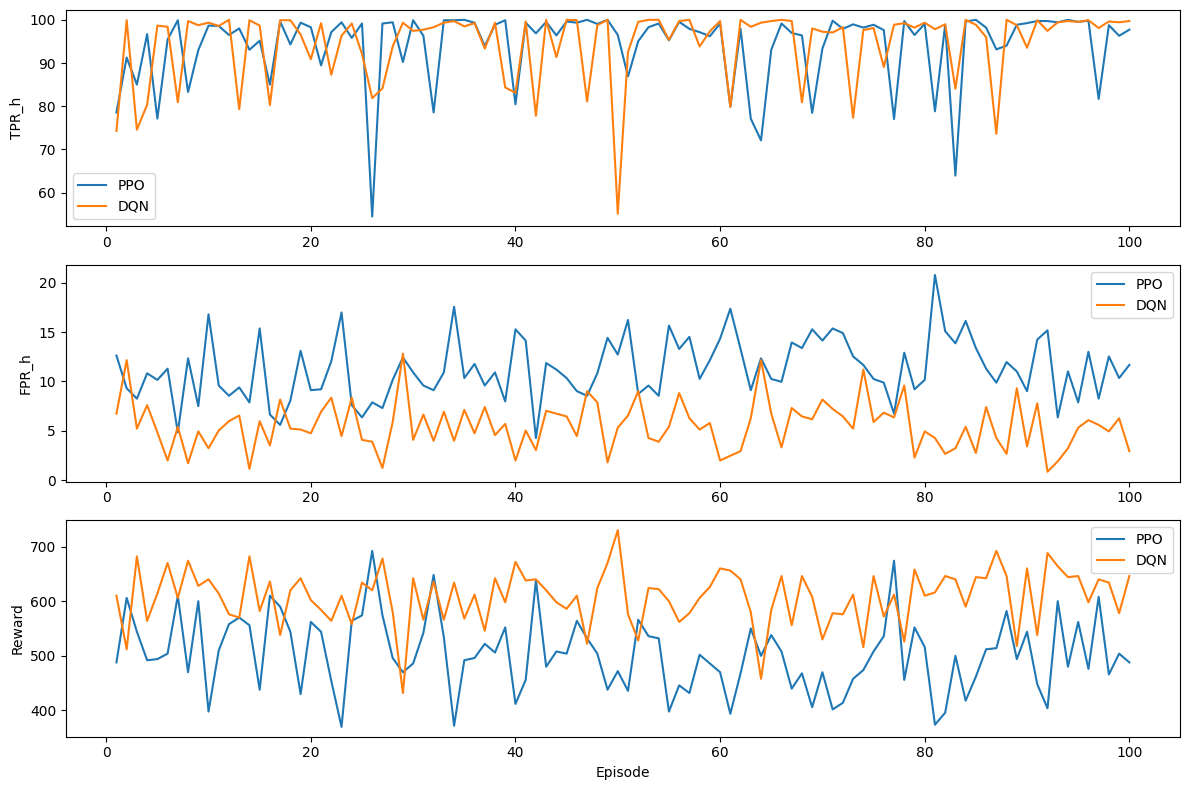

In [6]:
def my_evaluate_model(model, env, num_episodes=50,model_name = 'ppo'):
    tpr_hist = []
    fpr_hist = []
    rewards = []

    for episode in range(num_episodes):
        obs = env.reset()
        obs = obs[0]
        done = False
        total_reward = 0
        tpr_episode = []
        fpr_episode = []
        ep = 0

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            # bs, reward, terminated, truncated, info 
            obs, reward, done, truncated, info = env.step(action)
            total_reward += reward
            if not np.isnan(info['tp_rate']):
                tpr_episode.append(info['tp_rate'])
                fpr_episode.append(info['fp_rate'])
                # print(info)
                done = True
    
        if model_name == 'dqn':
            model.train(gradient_steps=10)
        else:
            model.train()
        tpr_hist.append(np.mean(tpr_episode))
        fpr_hist.append(np.mean(fpr_episode))
        rewards.append(total_reward)

    return tpr_hist, fpr_hist, rewards

snr = -2.5
data = c_states[snr]
# env = DummyVecEnv([lambda: FrequencyDetectionEnv(data)])
eval_env = TEST_FrequencyDetectionEnv(data)
num_episodes = 100

# Evaluate both models
tpr_ppo, fpr_ppo, rewards_ppo = my_evaluate_model(model_ppo, eval_env,num_episodes=num_episodes)
tpr_dqn, fpr_dqn, rewards_dqn = my_evaluate_model(model_dqn, eval_env,model_name='dqn',num_episodes=num_episodes)

episodes = range(1, num_episodes+1)

plt.figure(figsize=(12, 8))

# Plot TPR
plt.subplot(3, 1, 1)
plt.plot(episodes, tpr_ppo, label='PPO')
plt.plot(episodes, tpr_dqn, label='DQN')
plt.ylabel('TPR_h')
plt.legend()

# Plot FPR
plt.subplot(3, 1, 2)
plt.plot(episodes, fpr_ppo, label='PPO')
plt.plot(episodes, fpr_dqn, label='DQN')
plt.ylabel('FPR_h')
plt.legend()

# Plot Rewards
plt.subplot(3, 1, 3)
plt.plot(episodes, rewards_ppo, label='PPO')
plt.plot(episodes, rewards_dqn, label='DQN')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
model_ppo.save('ppo_snr0-5.zip')
model_dqn.save('dqn_snr0-5.zip')

In [9]:
with open('c_states_dict_acer_2.pkl', 'rb') as f:
    c_states_test = pickle.load(f)

c_states_test.keys()

dict_keys([5, 0, -5, -10, -15, -20, -25])

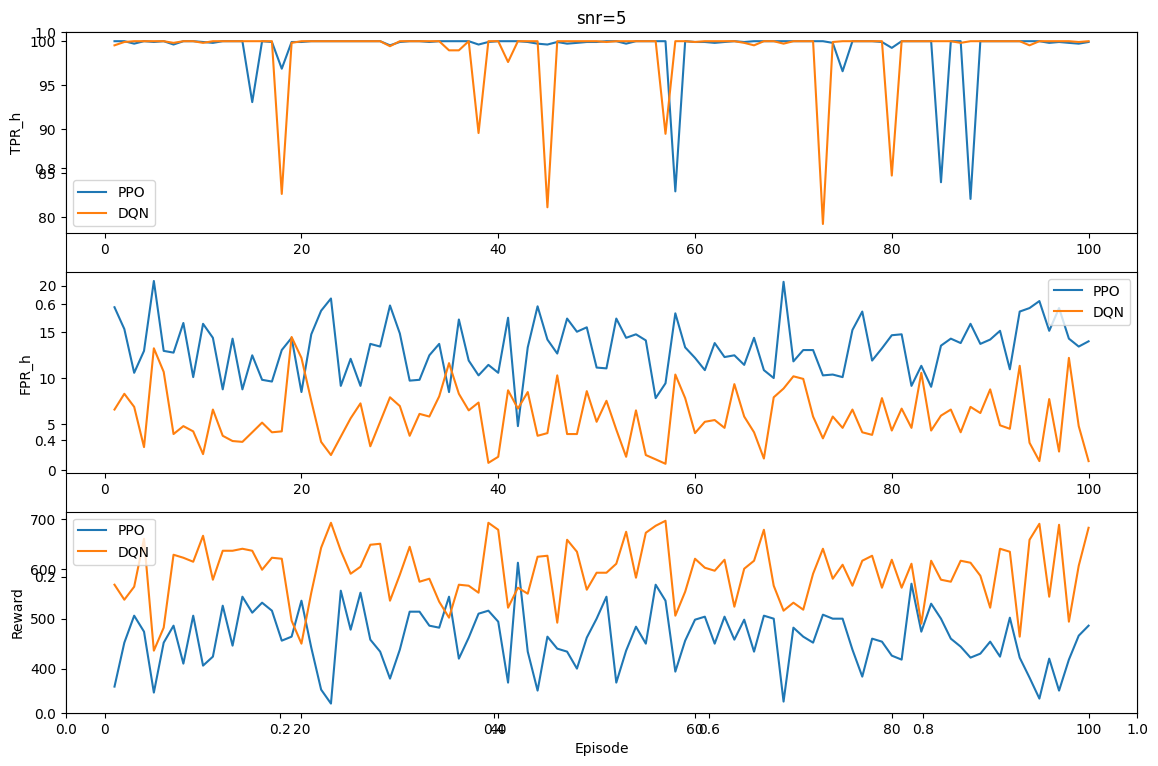

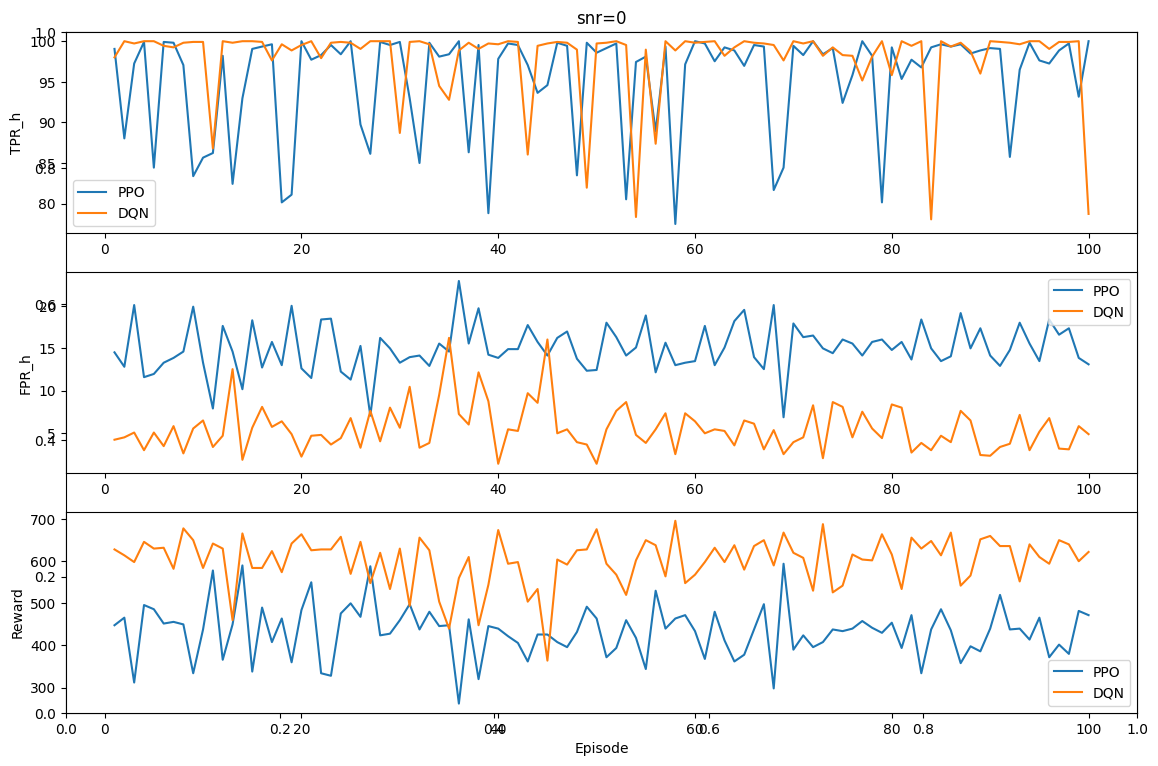

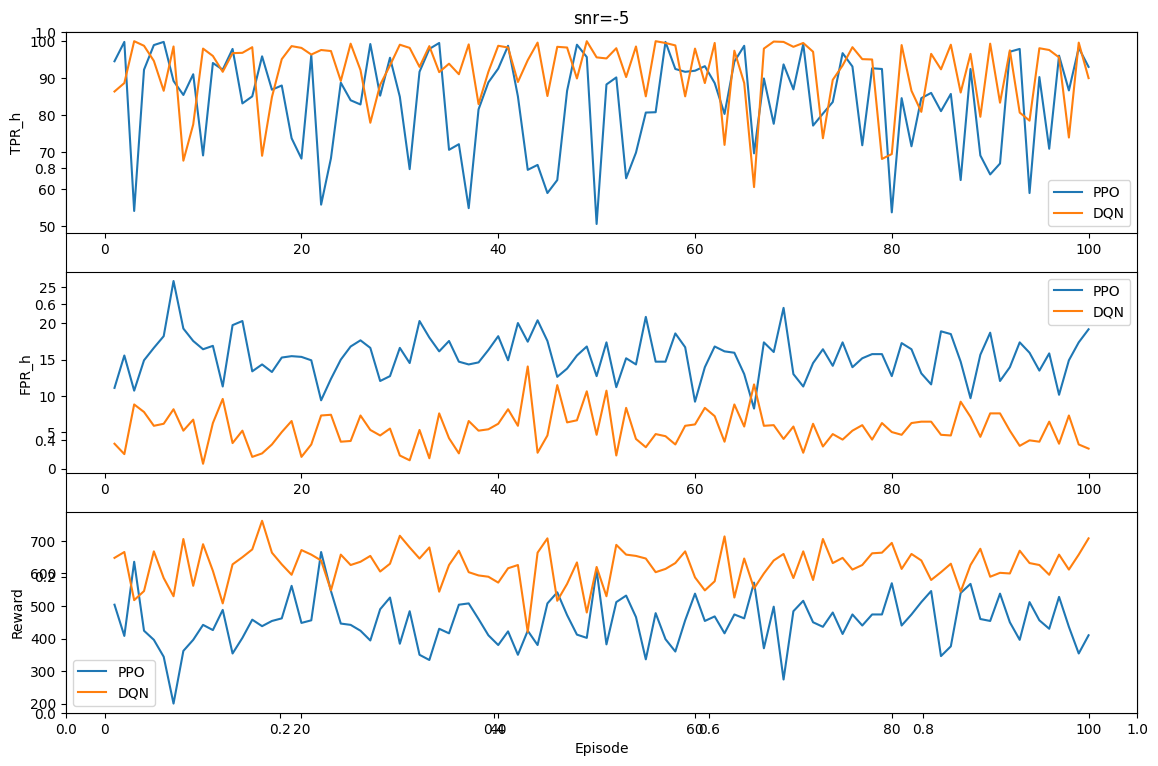

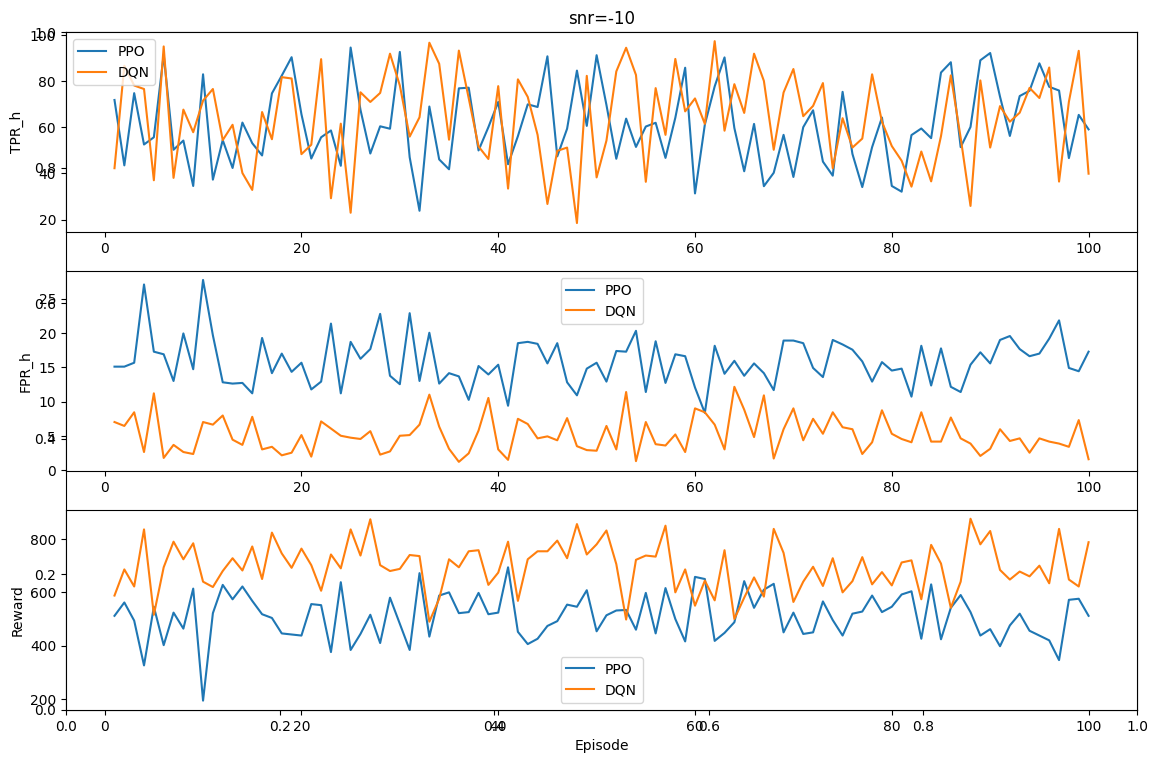

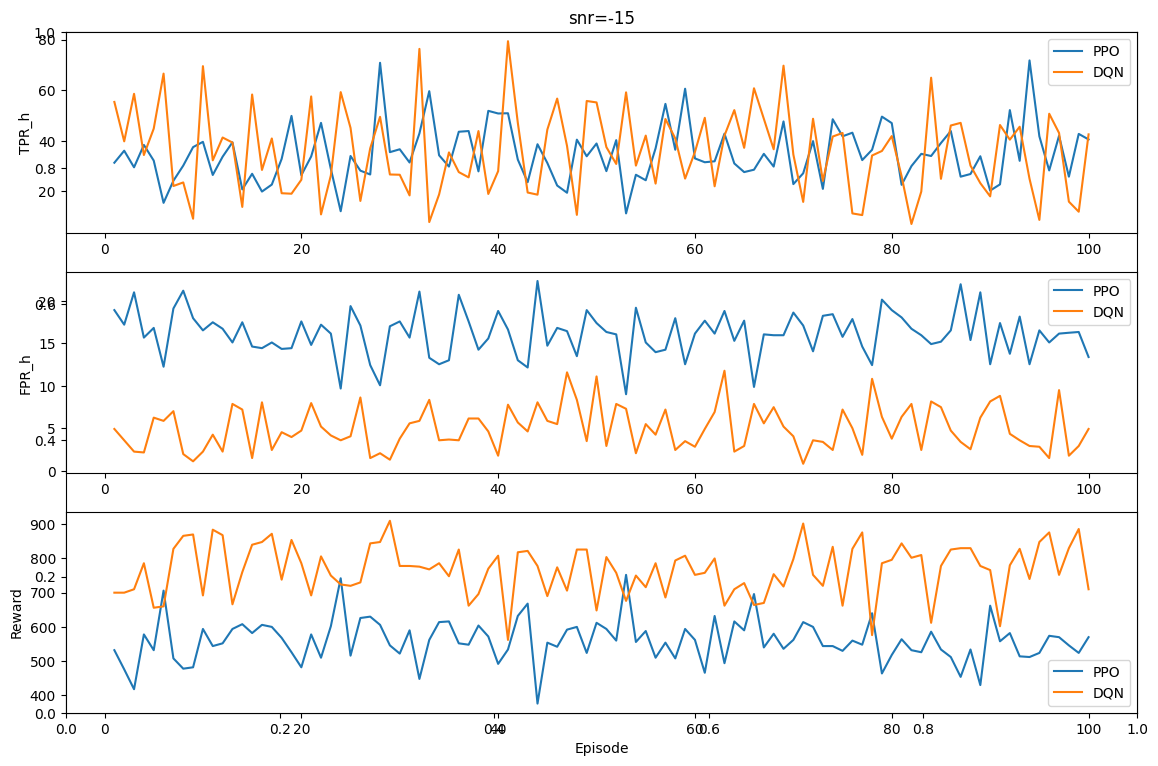

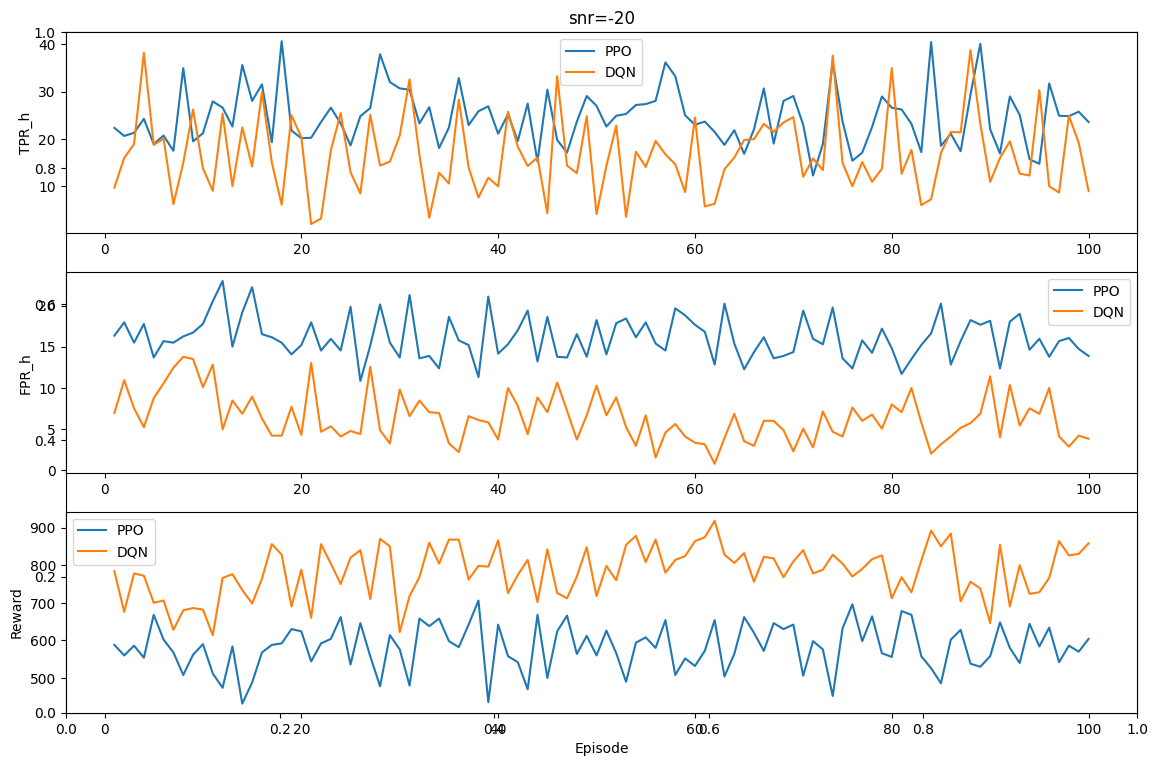

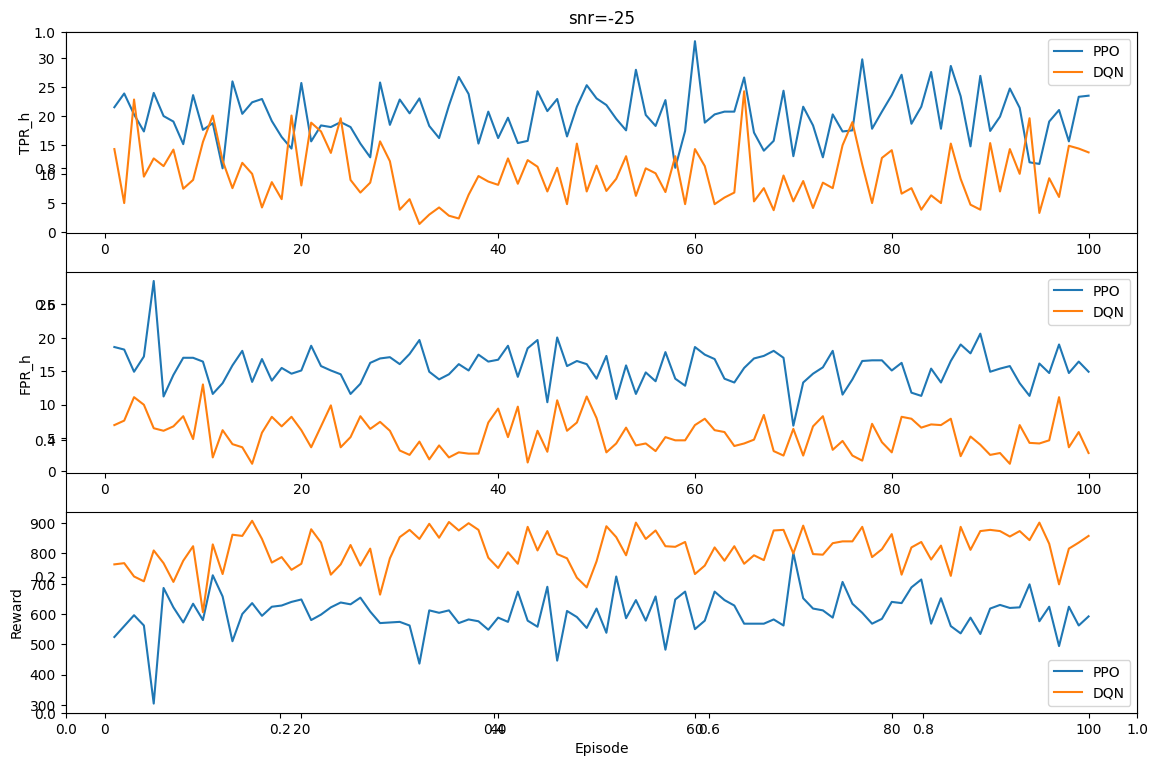

In [12]:
# for 
snr = -2.5
for snr in [5, 0, -5, -10, -15, -20, -25]:
    data = c_states_test[snr]
    # env = DummyVecEnv([lambda: FrequencyDetectionEnv(data)])
    eval_env = TEST_FrequencyDetectionEnv(data)
    num_episodes = 100

    # Evaluate both models
    tpr_ppo, fpr_ppo, rewards_ppo = my_evaluate_model(model_ppo, eval_env,num_episodes=num_episodes)
    tpr_dqn, fpr_dqn, rewards_dqn = my_evaluate_model(model_dqn, eval_env,model_name='dqn',num_episodes=num_episodes)

    episodes = range(1, num_episodes+1)

    plt.figure(figsize=(12, 8))

    # Plot TPR
    plt.title('snr='+str(snr))
    plt.subplot(3, 1, 1)
    plt.plot(episodes, tpr_ppo, label='PPO')
    plt.plot(episodes, tpr_dqn, label='DQN')
    plt.ylabel('TPR_h')
    plt.legend()

    # Plot FPR
    plt.subplot(3, 1, 2)
    plt.plot(episodes, fpr_ppo, label='PPO')
    plt.plot(episodes, fpr_dqn, label='DQN')
    plt.ylabel('FPR_h')
    plt.legend()

    # Plot Rewards
    plt.subplot(3, 1, 3)
    plt.plot(episodes, rewards_ppo, label='PPO')
    plt.plot(episodes, rewards_dqn, label='DQN')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()

    # plt.tight_layout()
    plt.show()